# Spit for Science (S4S)—1df GWAS Results Processing
**Author:** Jesse Marks <br>
**Date:** October 15, 2018 <br>
**GitHub Issue:** [#55](https://github.com/RTIInternational/bioinformatics/issues/55) <br>
**Data Retrieval:** `s3://rti-uploads/faliev` <br>
**Data Upload:** `s3://rti-nd/s4s/1df/results/`


This notebook documents the steps and procedures taken to process the GWAS results of the [Spit for Science (S4S)](https://spit4science.vcu.edu/) cohort. This cohort will be included in the updated wave 3 FTND meta-analysis (nicotine dependence). The aims in this document are to generate the Manhattan and QQ plots along with the corresponding lambda values. 

Once the S4S GWAS results have been processed for each ancestry they will be included in three meta-analyses:
1. EUR-specific
2. AFR-specific
3. cross-ancestry (include all 5 ancestry groups)
___

The S4S cohort includes GWAS results from 5 ancestry groups, namely:

* AFR, African
* AMR, Ad Mixed American
* EAS, East Asian
* EUR, European
* SAS, South Asian


**Notes:**
* We are missing the RSQ, MAF, and A2 data.
* We wrote a script extract the A2 data from 1000G_p3 reference panel, so that this obstacle was overcome
* Based on the results of this document, Dana Hancock suggested we proceed with only the AFR and EUR subjects from the S4S cohort for our wave-3 FTND meta-analyses.
    - Email sent by Dana on October 18, 2018:
    
```css
I suspect that what we’re seeing with the plots is a mix of small Ns for the underrepresented populations and low MAF/Rsq for all ancestries.

Because lambda~1 for EAs and AAs, while we wait for Fazil’s response, can you go ahead and run updated meta-analyses for EA only, AA only, and the EA+AA meta? Please be sure to exclude SNPs that are present in only a single cohort, which may help remove some of the low MAF/Rsq variants that will come through S4S.
```

# Create Directory Stucture & Download Data
This section should be modified each time.

In [ ]:
### Bash ###

# Variables to alter
################################################################################
ancestry_list='amr aa ea eas sas'
data_dir=/home/ec2-user/jmarks/nicotine/spit_science/
version="002"
s3_dir = "rti-uploads/faliev/"
################################################################################

# create directory structure for results processing
mkdir -p ${data_dir}/{original_results,processed_results}
for ancestry in ${ancestry_list};do
    mkdir -p ${data_dir}/processed_results/$version/${ancestry}
done

processing_dir=/shared/jmarks/nicotine/spit_science/processed_results/$version

for ancestry in ${ancestry_list}; do
    for (( chr=1; chr<23; chr++ )); do
        mkdir -p ${processing_dir}/$ancestry/processing/chr$chr 
    done
    mkdir ${processing_dir}/$ancestry/final
done

# Download data
aws s3 sync s3://${s3_dir} ${data_dir}/original_results

# unzip
gzip -d ${data_dir}/original_results* &

# File Prep
## Split up by chromosome
These GWAS results are all combined in one file. We will split them apart by chromosome first. Also note that for each of the ancestry partitioned results files, there were additional variants appended. Each file had variants for chromosomes 1-22 and then after chromosome 22 it started back with variants from chr1–12. Because of this, we had to edit the script traditionally used to split the GWAS results up by chromosome.

Original results file header:
```
 CHR    SNP         BP   A1       TEST    NMISS       BETA       SE      L95      U95         STAT            P
 ```
 
Variants counts (with header).
``` 
AFR_final_ftnd.summary.gz.line_count
29946601
::::::::::::::
AMR_final_ftnd.summary.gz.line_count
21316640
::::::::::::::
EAS_final_ftnd.summary.gz.line_count
12257686
::::::::::::::
EUR_final_ftnd.summary.gz.line_count
22655490
::::::::::::::
SAS_final_ftnd.summary.gz.line_count
14621298
```

In [ ]:
### Python ###

################################################################################
import gzip,sys
BASE_DIR = "/home/ec2-user/jmarks/nicotine/spit_science/"
processing_dir = "/shared/jmarks/nicotine/spit_science/processed_results/002/"
AFR = "AFR_final_ftnd.summary.gz"
AMR = "AMR_final_ftnd.summary.gz"
EAS = "EAS_final_ftnd.summary.gz"
EUR = "EUR_final_ftnd.summary.gz"
SAS = "SAS_final_ftnd.summary.gz"

data_list = [AFR,AMR,EAS,EUR,SAS]
ancestry_list = ['aa','amr','eas','ea','sas']

for data, ancestry in zip(data_list, ancestry_list):
    inF = gzip.open(BASE_DIR + "original_results/" + data)

    header = inF.readline().split()   # split header into a list
    chrIndex = header.index("CHR")    # chromosome
    pos_index = header.index("BP")    # position
    a2_index = header.index("A1") + 1
    header.insert(a2_index, "A2")
    header.insert(0, "Marker")
    lastChr = ''
    line = inF.readline()
    processed_list = []
    while(line): # while we are not at the end of the file
        split_line = line.split()
        current_chr = split_line[chrIndex]
        a2 = "" 
        split_line.insert(a2_index, a2)

        # if the new line is not the same chromosome as the last one processed enter loop
        # note it will enter this loop right from the gitgo because lastChr= '' by default
        if(current_chr != lastChr):
            proc_message = "Processing {}: Chr{}".format(ancestry, current_chr)
            print(proc_message)
            # keep track of which chromosomes have been processed
            processed_list.append(current_chr)
            times_processed = processed_list.count(current_chr)
            lastChr = current_chr # new last chromosome now

            # construct outfile name
            fname = 'sfs.' + ancestry + '.1000G.chr' + split_line[chrIndex] + '.' + 'CAT_FTND~1df_add.out.txt'
            out_dir = "{}/processing/chr{}/".format(ancestry, split_line[chrIndex])
            outF = file(processing_dir + out_dir + fname, 'a')

            # if the current chromosome has not been seen before then write a header to a new file
            if times_processed == 1:
                # write to a new file based on the new chr we are processing
                # also add the column Marker to the column header
                outF.write("\t".join(header) + "\n")
        # creating the Markername = CHR:POSITION in first field
        out_line = "{}:{}\t{}\n".format(split_line[chrIndex], split_line[pos_index], "\t".join(split_line))
        outF.write(out_line)
        #outF.write(split_line[chrIndex] + ":" + split_line[pos_index] + "\t" + "\t".join(split_line) + "\n")
        line = inF.readline() # read the next line

```
1000G_p3 snps: 29586624
Not 1000G_p3 snps: 359976

1000G_p3 snps: 20980356
Not 1000G_p3 snps: 336283

1000G_p3 snps: 22296807
Not 1000G_p3 snps: 358682

1000G_p3 snps: 11994628
Not 1000G_p3 snps: 263057

1000G_p3 snps: 14329701
Not 1000G_p3 snps: 291596
```

## Perform ID conversion 
Ultimately, we want to get IDs in 1000G phase3 format `rsID:position:A1:A2`. These data did not include a column for the Allele2. Some of the snpIDs are in 1000G_p3 format, but some of them are not. For the SNPs that are in 1000G_p3 format we can extract the Allele2 information from the ID. For the SNPs that are not in 1000G_p3 format we will have to perform a lookup in the 1000G_p3 reference panel. The rsIDs in the GWA results will be matched with the corresponding rsIDs in the 1000G_p3. We can then extract the Allele2 this way. 

To perform the above lookup description we will need to create a Python dictionary to store the SNP information from the 1000G_p3 reference panel. 

### 1000G_p3 SNP dictionary
A dictionary is created which has a variant's rsID as the key, and a list is return that contains the A1 and A2 alleles.

In [ ]:
def kp3_dict(chrom):
    """
    Create a dictionary for the 1000G_p3 snps.
    The key is the rsID and the value is a list of [A1,A2]
    """
    import gzip
################################################################################ 
    base_dir = "/shared/data/ref_panels/1000G/2014.10"
    in_file = "{}/1000GP_Phase3_chr{}.legend.gz".format(base_dir, chrom)
    thousand_dict = {}
    with gzip.open(in_file, "r") as inF:
        next(inF)
        line = inF.readline()
        while line:
            uniq_id = line.split()[0]
            uniq_id = uniq_id.split(":") 
            rs_id = uniq_id[0]
            position = uniq_id[1]
            a1 = uniq_id[2]
            a2 = uniq_id[3]
            thousand_dict[rs_id] = [rs_id, position, a1, a2]
            line = inF.readline()
    message = "Done creating dictionary for chr{} 1000G_p3 reference panel.".format(chrom)
    print(message)
    return thousand_dict

thou_dict = kp3_dict(15)


### Convert SNP to 1000G_p3 format

In [ ]:
import sys

def convert_snp(base_dir, ancestry, study, chrom):
    """Convert snps to 1000G phase 3 format"""
    import gzip
    thou_dict = kp3_dict(chrom) # reference panel dictionary of SNPs
    
    in_name = "{}.{}.1000G.chr{}.CAT_FTND~1df_add.out.txt".format(study, ancestry, chrom)
    file_dir = "{}/{}/processing/chr{}/".format(base_dir, ancestry, chrom)
    with open(file_dir + in_name, "r") as inF:
        #leg_file = "/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr{}.legend.gz".format(chrom)
        out_name = "{}.{}.1000G.chr{}.CAT_FTND~1df.phase3ID_add.out.txt".format(study, ancestry, chrom)
        with open(file_dir + out_name, "w") as outF:
            header = inF.readline()
            outF.write(header)
            
            snp_index = header.split().index("SNP")
            a1_index = header.split().index("A1")
            a2_index = header.split().index("A2")
            phase3_index = header.split().index("Marker") # updated SNP id
            
            line = inF.readline()
            
            while line:
                snp = line.split()[snp_index]
                snp_split = snp.split(":")
                a1 = line.split()[a1_index]
                snp_id = snp_split[0]
                
                split_line = line.split()
                if len(snp_split) >= 4: # indicates already in 1000G_p3 format
                    split_line[phase3_index] = snp
                    split_line[a2_index] = snp_split[3] # fill in A2 data
                    new_line = "\t".join(split_line)
                    outF.write(new_line + "\n")
                    
                # if not already in 1000G_p3 format, search for it in ref panel 
                # which is in dictionary we created
                elif (len(snp_split) == 1) and (snp_id[:2] == "rs"): 
                    try:
                        marker_name = ":".join(thou_dict[snp_id])
                        potential_a1 = thou_dict[snp_id][2]
                        potential_a2 = thou_dict[snp_id][3]
                        
                        if a1 == potential_a1:
                            a2 = potential_a2
                            split_line[a2_index] = a2
                            split_line[phase3_index] = marker_name
                            new_line = "\t".join(split_line)
                            outF.write(new_line + "\n")
                        elif a1 == potential_a2:
                            a2 = potential_a1
                            split_line[a2_index] = a2
                            split_line[phase3_index] = marker_name
                            new_line = "\t".join(split_line)
                            outF.write(new_line + "\n")
                        else:
                            continue 
                    except KeyError: # rsID not in ref panel dictionary
                        pass
                else:
                    pass
                line = inF.readline()
    print("Done")
    
# base_dir = "/home/ec2-user/jmarks/nicotine/spit_science/processed_results/002"
# ancestry = "sas"
# study = "sfs"
# chrom = 15

# print(sys.argv[0])
# print(sys.argv[1])
# print(sys.argv[2])
# print(sys.argv[3])
# convert_snp(base_dir, ancestry, study, chrom)

### debug
A function to count how many SNPs are in 1000G_p3 format.

In [ ]:
# BASE_DIR = "/home/ec2-user/jmarks/nicotine/spit_science/"
# AFR = "AFR_final_ftnd.summary.gz"
# AMR = "AMR_final_ftnd.summary.gz"
# EAS = "EAS_final_ftnd.summary.gz"
# EUR = "EUR_final_ftnd.summary.gz"
# SAS = "SAS_final_ftnd.summary.gz"
# data_list = [AFR,AMR,EAS,EUR,SAS]
# ancestry_list = ['aa','amr','eas','ea','sas']
#data_list = [SAS]
#ancestry_list = ['sas']

def snp_count(data_dir, out_dir, data_list, ancestry_list):
    """
    Count the number of variants that are in 1000G phase3 format
    and also the number of variants that are not in that format.
    
    INPUT:
    base_dir      - (string) path to base directory
    out_dir       - (string) path to directory where file will be written to
    data_list     - (list) list of strings. The strings are the GWA data file names
    ancestry_list - (list) list of ancestries corresponding to the GWA data (must be in same order as <data_list>
    """
    import gzip,sys

    thou = 0 # initialize 1000G_p3 count
    not_thou = 0 # initialize NON-1000G_p3 count
    for data, ancestry in zip(data_list, ancestry_list):
        inF = gzip.open(data_dir + data)
    # 
        header = inF.readline().split()   # split header into a list
        line = inF.readline()
        while line: 
            count += 1
            snp = line.split()[1]
            snp_split = snp.split(":")
            if len(snp_split) > 1:
                thou += 1
            else:
                not_thou += 1
    #             
            line = inF.readline()
        
        with open(out_dir + ancestry + "_snp.counts", "w") as outF:
            message = "1000G_p3 snps: {} \nNot 1000G_p3 snps: {}\n\n".format(thou, not_thou)
            outF.write(message)
return ;

#snp_count(data_dir, out_dir, data_list, ancestry_list)

## Filtering by MAF+RSQ 
### Create MAF filtered (ancestry specific) reference files

In [ ]:
### START Filter ###
# create 1000G_p3 MAF filtered files
thouDir=/shared/data/ref_panels/1000G/2014.10
# AFR 
for chr in {1..22};do
    awk ' { if ( $6>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_afr
done &

# AMR 
for chr in {1..22};do
    awk ' { if ( $7>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_amr
done &

# EAS 
for chr in {1..22};do
    awk ' { if ( $8>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_eas
done &

# EUR
for chr in {1..22};do
    awk ' { if ( $9>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_eur
done &

#  SAS
for chr in {1..22};do
    awk ' { if ( $10>=0.01 ) { print $1 } }' <(zcat $thouDir/1000GP_Phase3_chr$chr.legend.gz) >\
        $thouDir/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_sas
done &

### MAF by Ancestry+Study
No MAF column in the S4S GWA data. We will therefore only filter by MAF with the SNPs in the 1000_p3 reference panel.

In [ ]:
### Bash ### 
# thou_dir="/shared/data/ref_panels/1000G/2014.10"
# ancestry_list="aa amr ea eas sas" 
# study="sfs"

# MAF > 0.01 in each ancestry group 
for ancestry in $ancestry_list; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "amr" ]; then
        group=amr
    elif [ $ancestry == "eas" ]; then
        group=eas
    elif [ $ancestry == "sas" ]; then
        group=sas
    else
        group=eur
    fi

    for (( chr=1; chr<23; chr++ )); do
        if [ $chr == "23" ]; then
            idList=${thou_dir}/1000GP_Phase3_chrX_NONPAR.maf_lte_0.01_$group
        else
            idList=${thou_dir}/1000GP_Phase3_chr$chr.legend.maf_lte_0.01_$group
        fi

        inF="${base_dir}/$ancestry/processing/chr$chr/${study}.$ancestry.1000G.chr$chr.CAT_FTND~1df.phase3ID_add.out.txt"
        outF="${base_dir}/$ancestry/processing/chr$chr/${study}.$ancestry.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$group"
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_$chr\
            --script_prefix $outF \
            --mem 3.8 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
                --source $inF \
                --id_list $idList \
                --out $outF \
                --header 1 \
                --id_column 0 
    done
done

# # MAF > 0.01 in study
# for ancestry in ${ancestry_list}; do
#     if [ $ancestry == "aa" ]; then
#         group=afr
#     elif [ $ancestry == "amr" ]; then
#         group=amr
#     elif [ $ancestry == "eas" ]; then
#         group=eas
#     elif [ $ancestry == "sas" ]; then
#         group=sas
#     else
#         group=eur
#     fi
#     for (( chr=1; chr<23; chr++ )); do
#         inFile=${base_dir}/$ancestry/processing/chr$chr/${study}.$ancestry.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$group
#         outFile=${inFile}+${study}
#         echo Processing $inFile
#         head -n 1 $inFile > $outFile
#         tail -n +2 $inFile |
#             perl -lane 'if ($F[6] >= 0.01 & $F[6] <= 0.99) { print; }' >> $outFile
#     done
# done

### RSQ
No RSQ column in the S4S GWA data. We will therefore skip this processing step.

In [ ]:
# # RSQ > 0.3 in study
# for ancestry in ${ancestry_list}; do
#     if [ $ancestry == "aa" ]; then
#         group=afr
#     elif [ $ancestry == "amr" ]; then
#         group=amr
#     elif [ $ancestry == "eas" ]; then
#         group=eas
#     elif [ $ancestry == "sas" ]; then
#         group=sas
#     else
#         group=eur
#     fi

#     for (( chr=1; chr<23; chr++ )); do
#         inFile=${base_dir}/$ancestry/processing/chr$chr/${study}.$ancestry.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.${group}+${study}
#         outFile=${inFile}.RSQ
#         echo Processing $inFile
#         head -n 1 $inFile > $outFile
#         tail -n +2 $inFile |
#             perl -lane 'if ($F[17] > 0.3) { print; }' >> $outFile
#     done
# done

# Plotting
Generate Manhattan and QQ plots so we can inspect the lambda and determine if genomic control needs to be applied. Genomic control is applied when the lambda is inflated which would suggest population structure.

In [ ]:
#### Bash ###

### START Generate plots ###
for ancestry in ${ancestry_list}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "amr" ]; then
        group=amr
    elif [ $ancestry == "eas" ]; then
        group=eas
    elif [ $ancestry == "sas" ]; then
        group=sas
    else
        group=eur
    fi
    #for ext in $group ${group}+${study} ${group}+${study}.RSQ; do
        ext=$group
        outFile=${base_dir}/$ancestry/processing/${study}.$ancestry.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.table
        echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile

        for (( chr=1; chr<23; chr++ )); do
            inFile=${base_dir}/$ancestry/processing/chr$chr/${study}.${ancestry}.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$ext
            echo Processing $inFile #14
            tail -n +2 $inFile |
                perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){6}\s+(\S+)/;
                            if (($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T") && ($6 eq "A" || $6 eq "C" || $6 eq "G" || $6 eq "T")) {
                            print join("\t",$1,$2,$4,$8,"snp");
                            } else { print join("\t",$1,$2,$4,$8,"indel"); }' >> $outFile
        done
    #done
done
for ancestry in ${ancestry_list}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "amr" ]; then
        group=amr
    elif [ $ancestry == "eas" ]; then
        group=eas
    elif [ $ancestry == "sas" ]; then
        group=sas
    else
        group=eur
    fi

    #for ext in $group ${group}_minnesota_twins ${group}_minnesota_twins_RSQ; do
        ext=$group
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_gwas_plots \
            --script_prefix ${base_dir}/$ancestry/processing/$study.$ancestry.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.plots \
            --mem 15 \
            --priority 0 \
            --program /shared/bioinformatics/software/R/generate_gwas_plots.R \
                --in ${base_dir}/$ancestry/processing/$study.$ancestry.1000G.CAT_FTND~1df.maf_gt_0.01_$ext.table \
                --in_chromosomes autosomal_nonPAR \
                --in_header \
                --out ${base_dir}/$ancestry/processing/$study.$ancestry.1000G.CAT_FTND~1df.maf_gt_0.01_$ext \
                --col_id VARIANT_ID \
                --col_chromosome CHR \
                --col_position POSITION \
                --col_p P \
                --col_variant_type TYPE \
                --generate_snp_indel_manhattan_plot \
                --manhattan_odd_chr_color red \
                --manhattan_even_chr_color blue \
                --manhattan_points_cex 1.5 \
                --generate_snp_indel_qq_plot \
                --qq_lines \
                --qq_points_bg black \
                --qq_lambda
    #done
done

for ancestry in ${ancestry_list};do
    mv ${base_dir}/$ancestry/processing/*.png \
        ${base_dir}/$ancestry/final
done

### END Generate plots ###



# Filter to top Pvalues
Filter to $Pvalue < 0.001$.

In [ ]:
### Bash ###

### START Filter by p-value ###

# MAF > 0.01 in AFR and EUR
for ancestry in ${ancestry_list}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    elif [ $ancestry == "amr" ]; then
        group=amr
    elif [ $ancestry == "eas" ]; then
        group=eas
    elif [ $ancestry == "sas" ]; then
        group=sas
    else
        group=eur
    fi
    #for ext in $group ${group}_$study do
        ext=$group
        outFile=${base_dir}/$ancestry/processing/$study.$ancestry.1000G_p3.CAT_FTND~1df.maf_gt_0.01.$ext.p_lte_0.001
        head -n 1 ${base_dir}/$ancestry/final/$study.$ancestry.1000G_p3.chr1.CAT_FTND~1df.maf_gt_0.01.$ext > $outFile
        for (( chr=1; chr<23; chr++ )); do
            inFile=${base_dir}/$ancestry/final/$study.$ancestry.1000G_p3.chr$chr.CAT_FTND~1df.maf_gt_0.01.$ext
            echo Processing $inFile
            tail -n +2 $inFile |
              perl -lane 'if ($F[13] <= 0.001) { print; }' >> $outFile
        done
    #done
done



### Sort filtered Pvalues

In [ ]:
### R ###
base_dir <- "/shared/jmarks/nicotine/spit_science/processed_results/002/"
cohort <- "sfs"

# Sort
for (ancestry in c("aa", "amr","ea","eas", "sas")){
    if (ancestry == "aa") { group = "afr" } 
    else if (ancestry == "amr") { group = "amr" }
    else if (ancestry == "ea") { group = "eur" }
    else if (ancestry == "eas") { group = "eas" }
    else { group = "sas" }
    
    dat=read.table(paste0(base_dir , ancestry, '/processing/', 
                          cohort, '.',ancestry,'.1000G_p3.CAT_FTND~1df.maf_gt_0.01_',
                          group,'.p_lte_0.001'), header = TRUE)
    dat = dat[order(dat$P),]
    write.csv(dat,
            file = paste0(base_dir , ancestry, '/final/', cohort, '.',ancestry,
                          '.1000G_p3.CAT_FTND~1df.maf_gt_0.01_',
                          group,'.p_lte_0.001.csv'), row.names = FALSE)
}

## END Filter by p-value ###

# View Manhattan & QQ Plots
## AFR

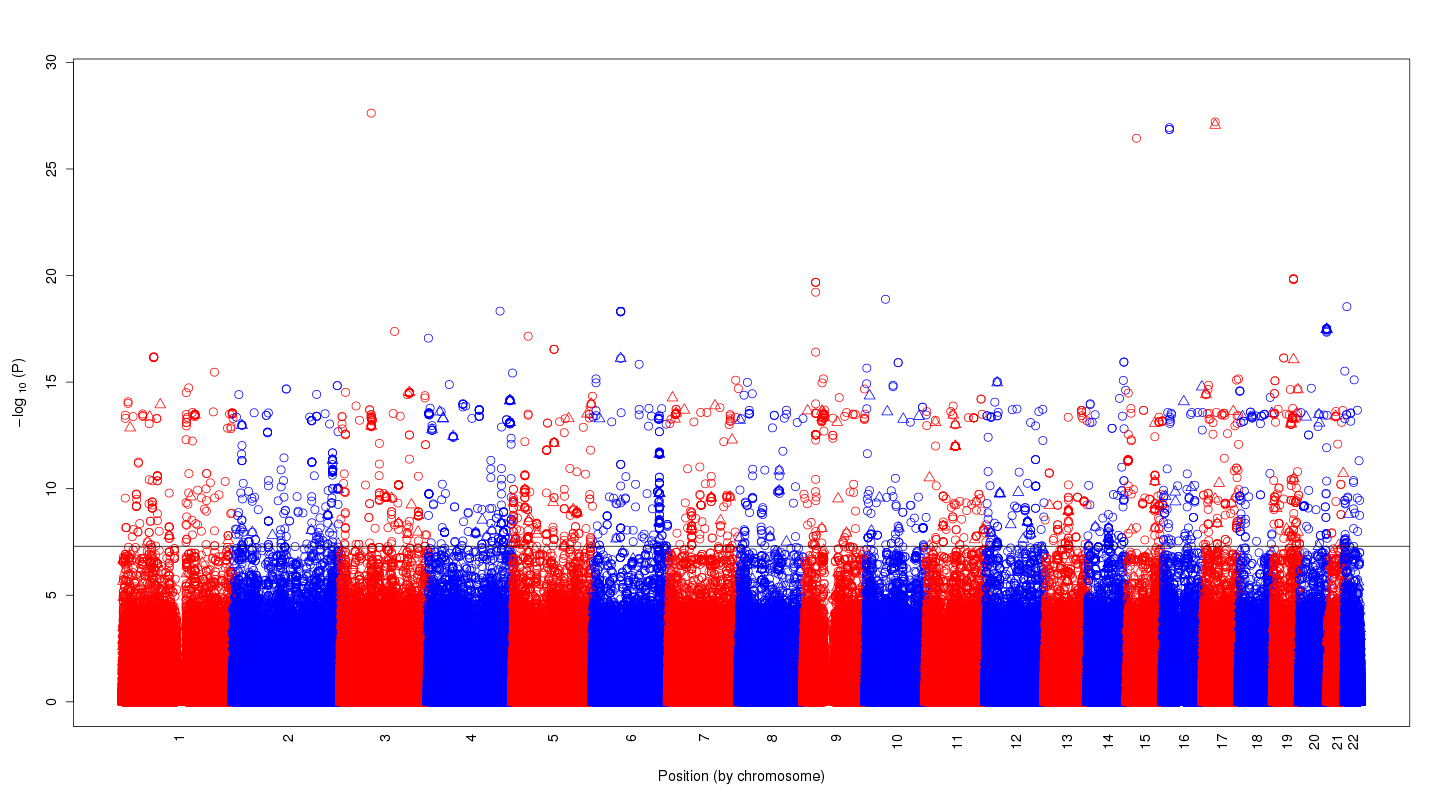

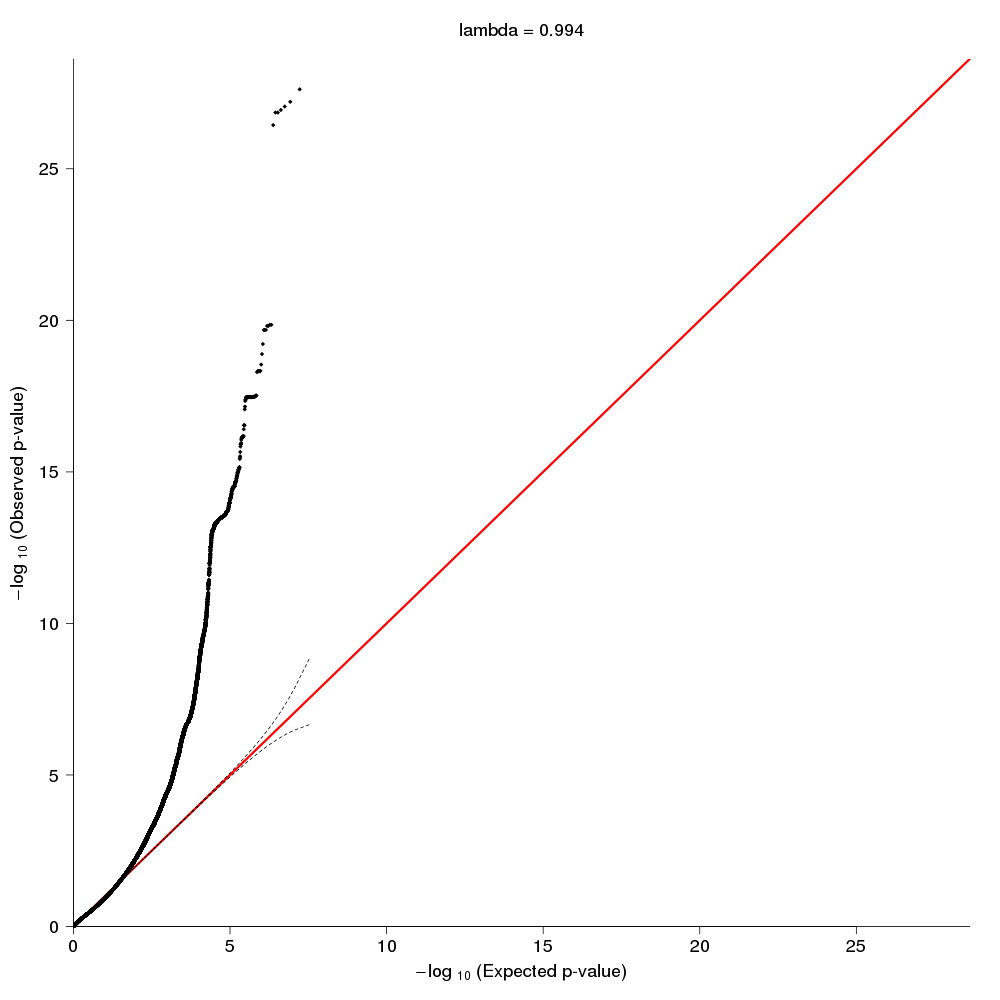

In [3]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/aa/sfs.aa.1000G.CAT_FTND~1df.maf_gt_0.01_afr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/aa/sfs.aa.1000G.CAT_FTND~1df.maf_gt_0.01_afr.snps+indels.qq.png")  

## AMR

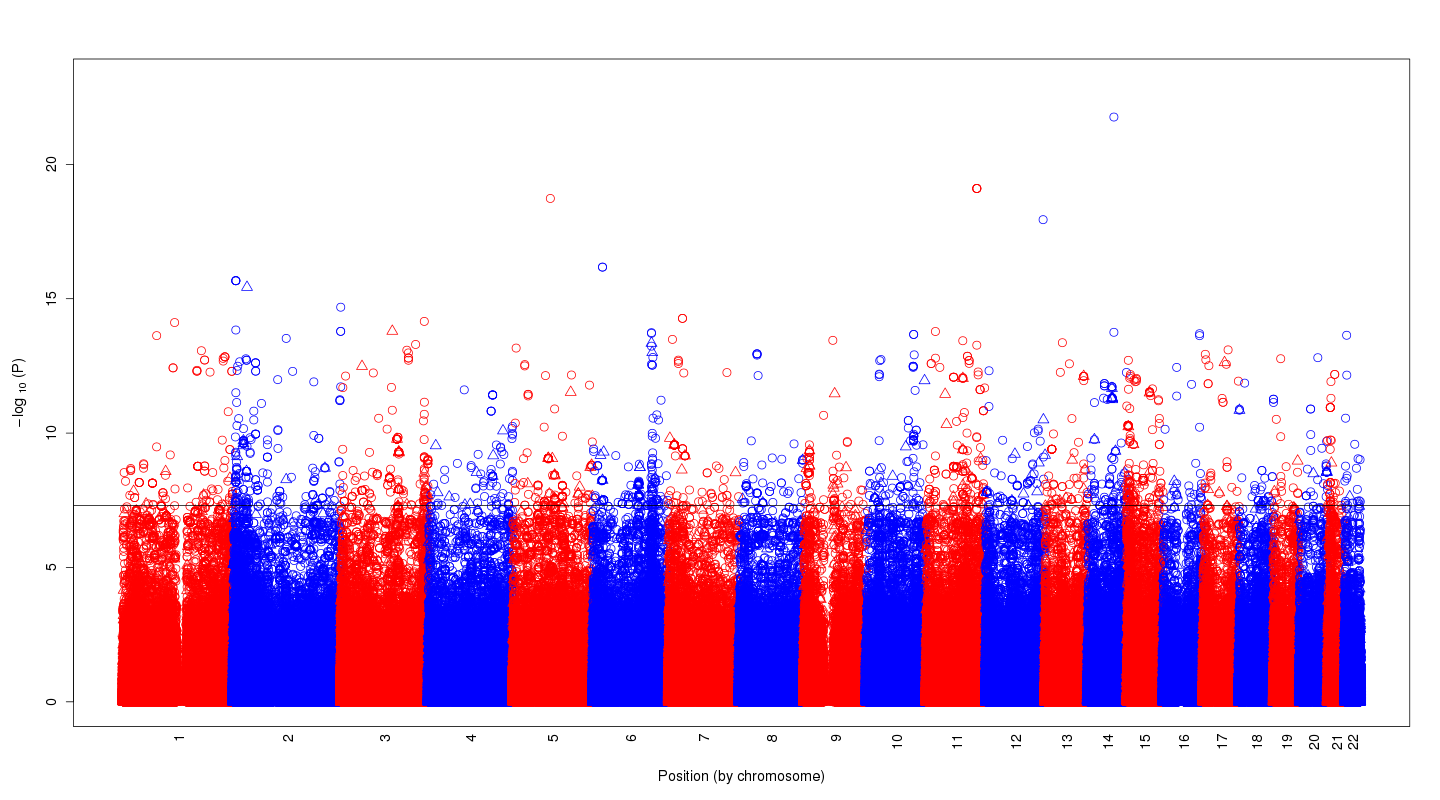

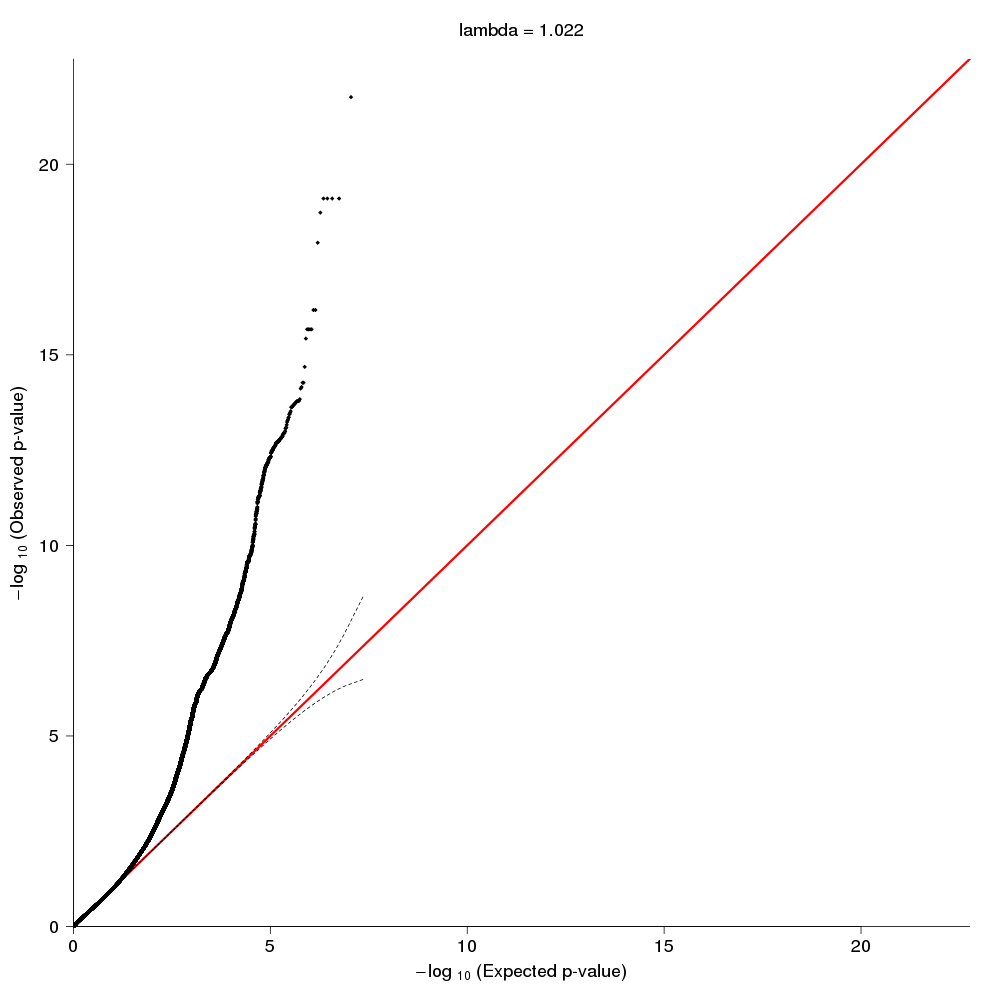

In [4]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/amr/sfs.amr.1000G.CAT_FTND~1df.maf_gt_0.01_amr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/amr/sfs.amr.1000G.CAT_FTND~1df.maf_gt_0.01_amr.snps+indels.qq.png")  


## EUR

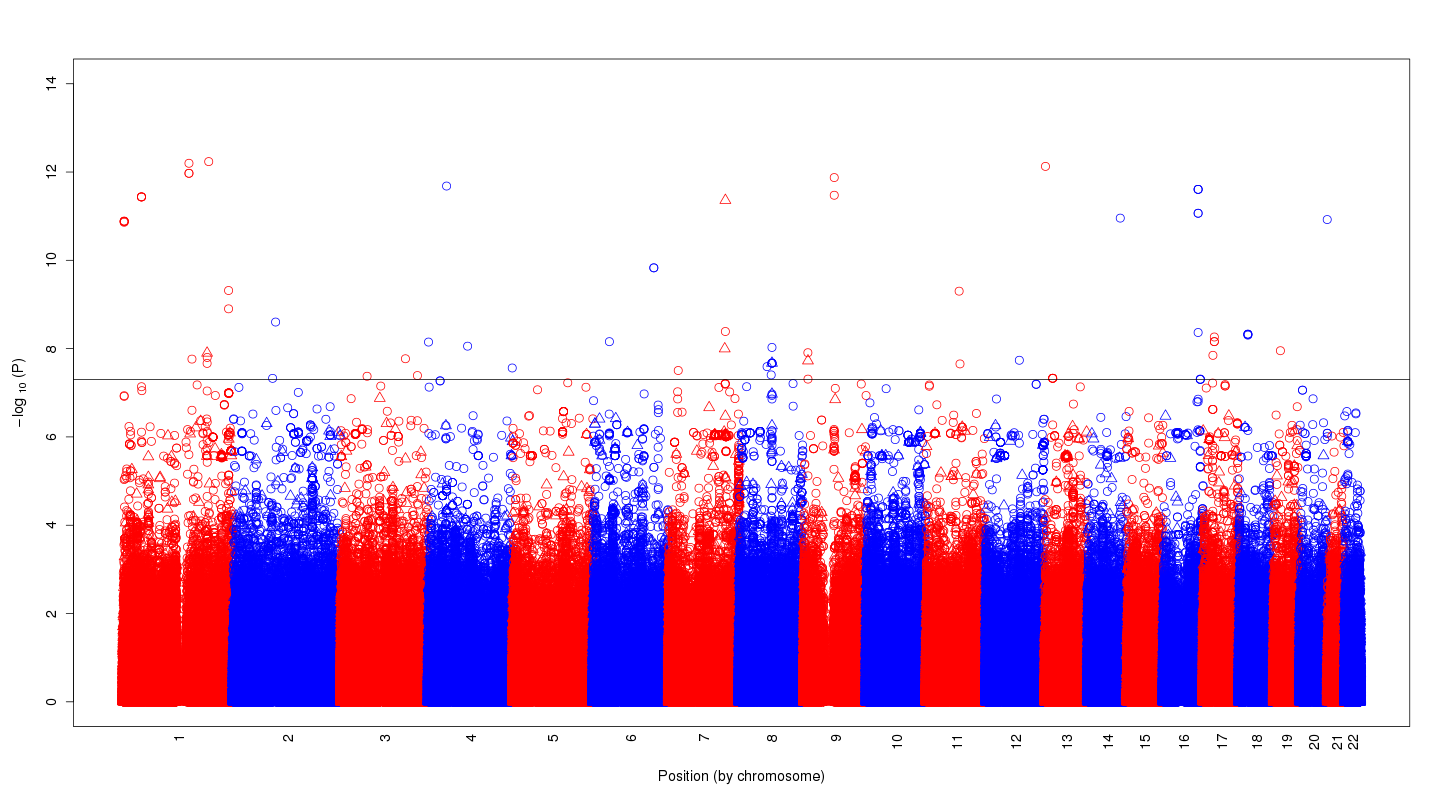

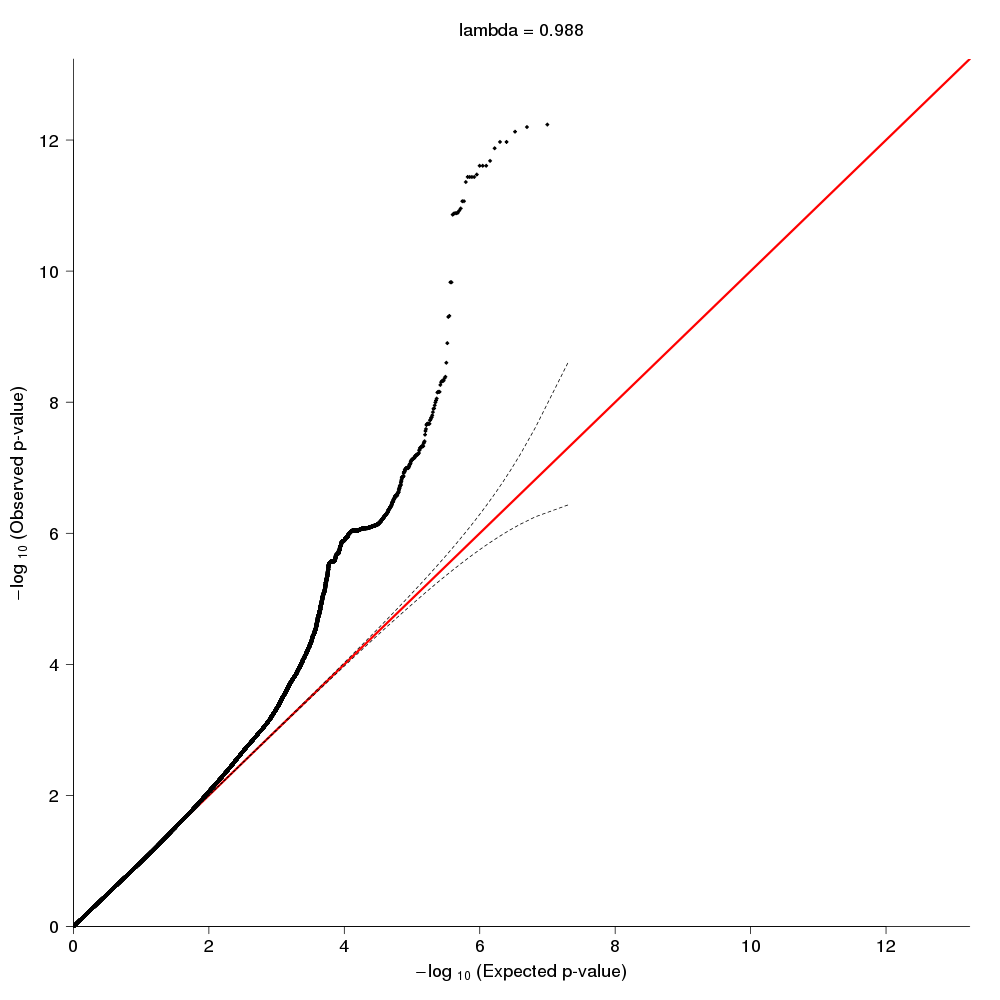

In [6]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/eur/sfs.ea.1000G.CAT_FTND~1df.maf_gt_0.01_eur.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/eur/sfs.ea.1000G.CAT_FTND~1df.maf_gt_0.01_eur.snps+indels.qq.png")  

## EAS

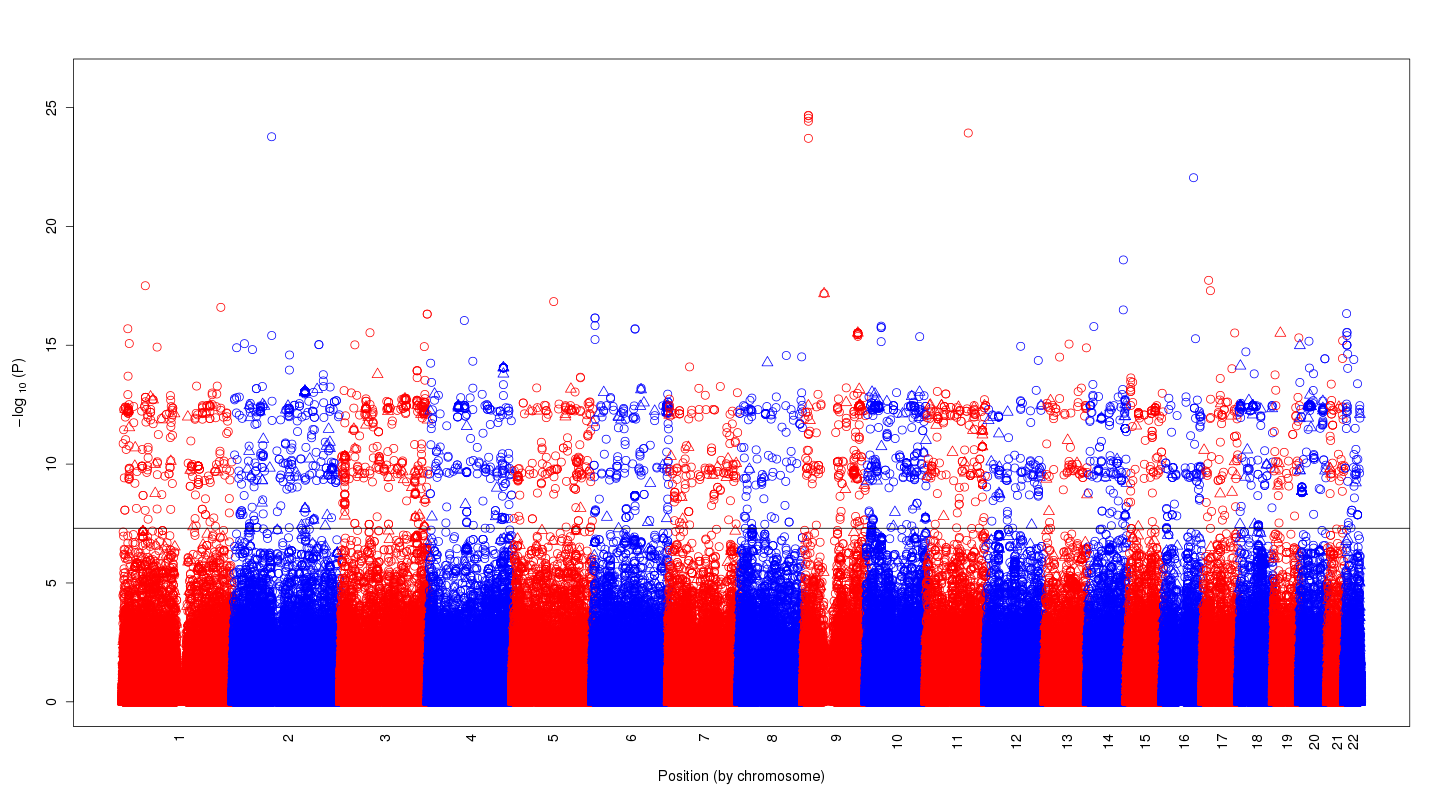

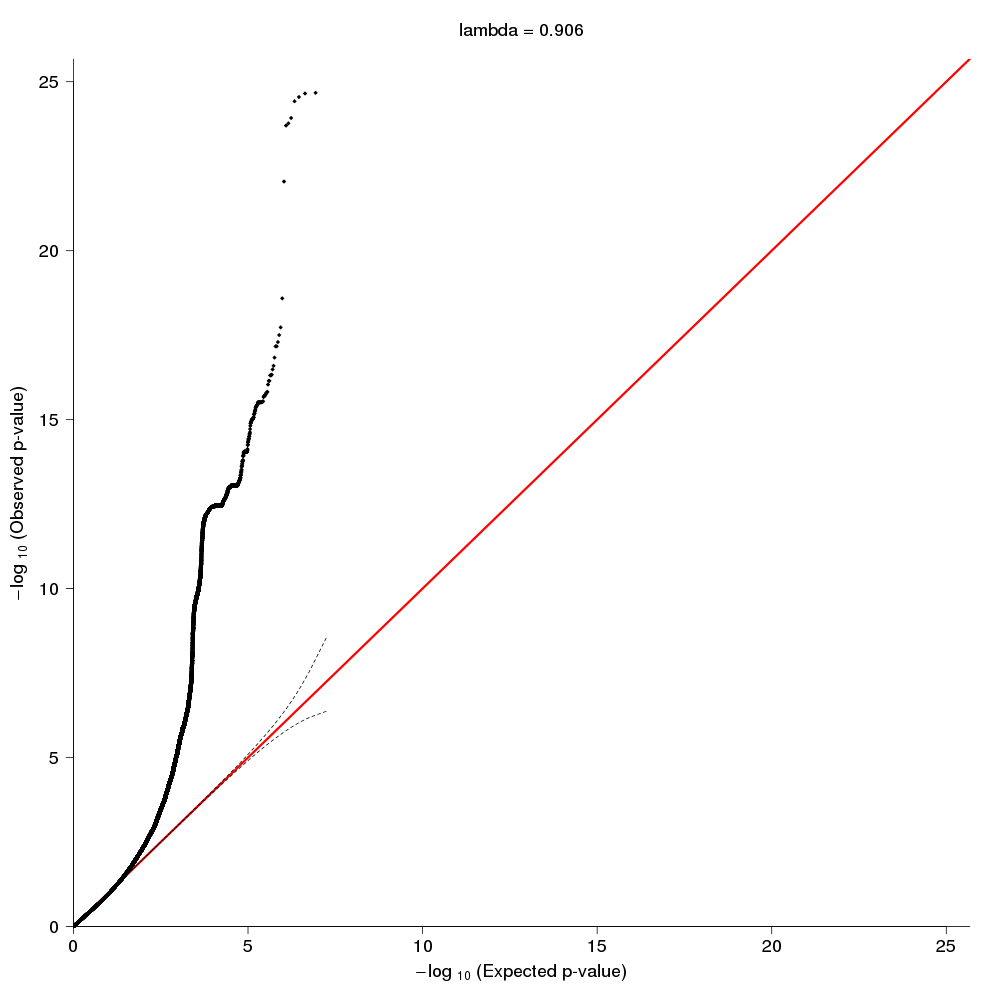

In [7]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/eas/sfs.eas.1000G.CAT_FTND~1df.maf_gt_0.01_eas.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/eas/sfs.eas.1000G.CAT_FTND~1df.maf_gt_0.01_eas.snps+indels.qq.png")  

## SAS

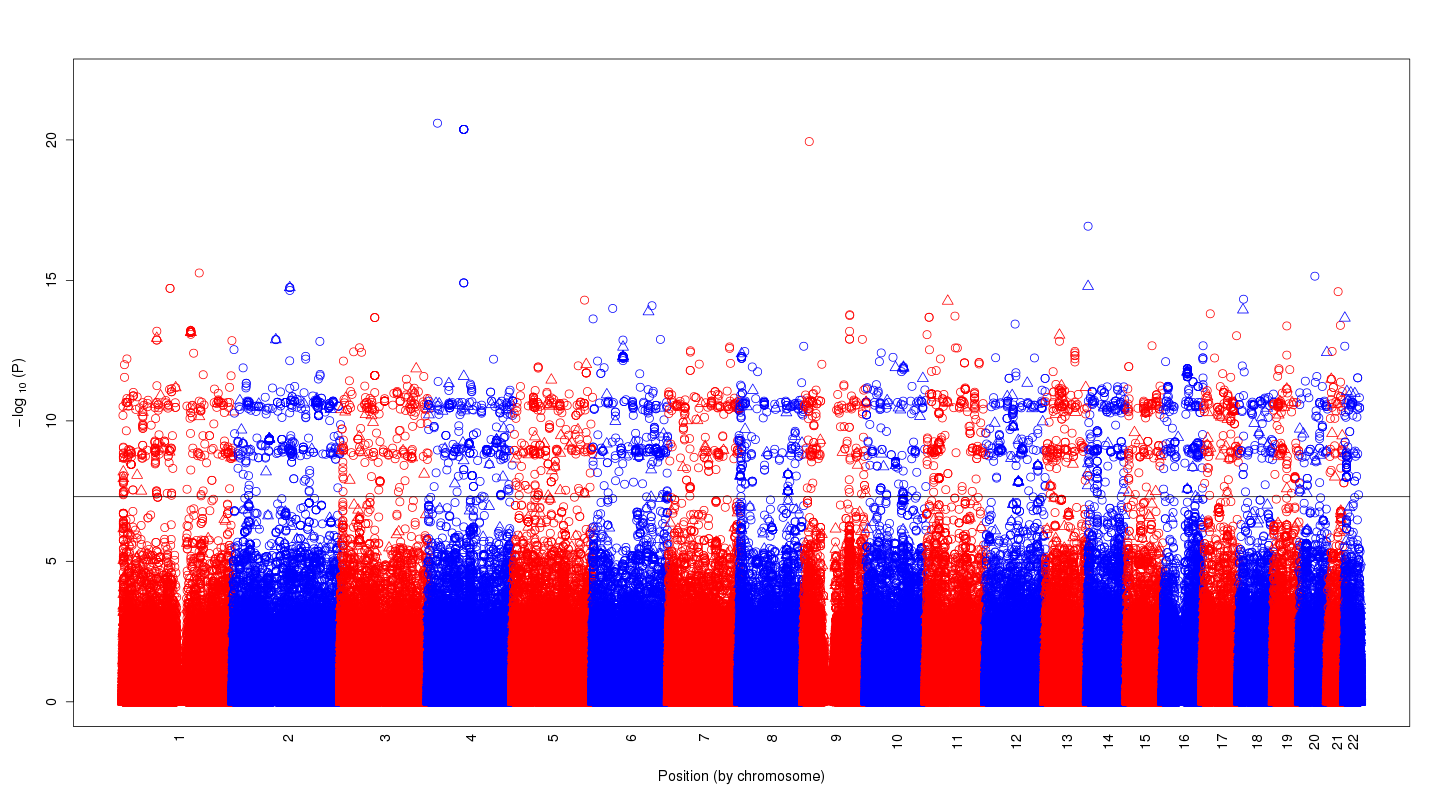

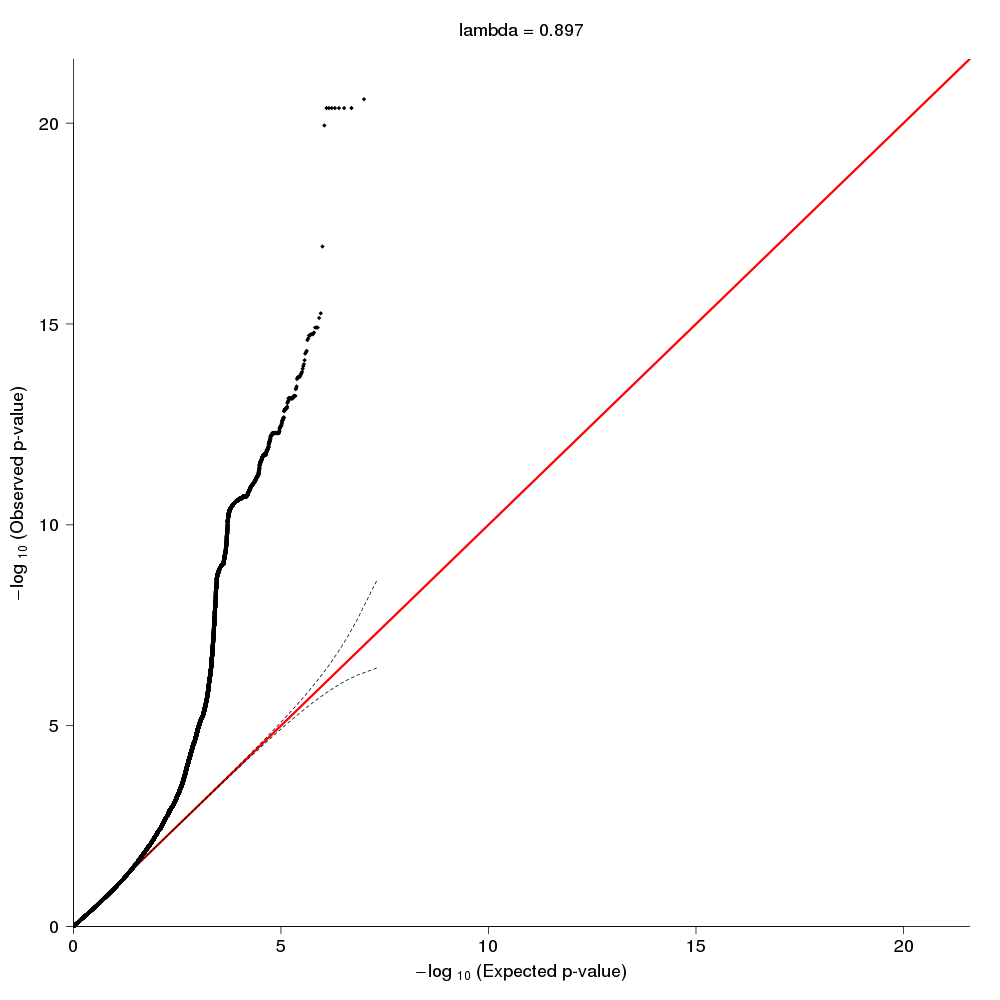

In [8]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/sas/sfs.sas.1000G.CAT_FTND~1df.maf_gt_0.01_sas.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Nicotine/sfs/sas/sfs.sas.1000G.CAT_FTND~1df.maf_gt_0.01_sas.snps+indels.qq.png")  


# Upload to S3

In [ ]:
# EC2
cd /home/ec2-user/jmarks/nicotine/spit_science/processed_results/002

aws s3 sync . s3://rti-nd/S4S/results/20181019 --quiet &

# remove processing files
ancestry_list="aa amr ea eas sas"
for ancestry in ${ancestry_list};do
    aws s3 rm s3://rti-nd/S4S/results/20181019/$ancestry/processing/ --recursive --quiet &
done